<a href="https://colab.research.google.com/github/dominiksakic/generative_ai/blob/main/deepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Normally, inputs is fixed and the model changes.
- Here we will fix  the model and change the inputs.

- How?
- Maximize the feature activation in the network.

  - Choose a layer
  - Compute how much that layer activates for a given image
  - calculate the gradient.
  - adjust the iamge to INCREASE those activations
  - In simple Deutsch: " What kind of changes to this images would make the network see more of certain features?"


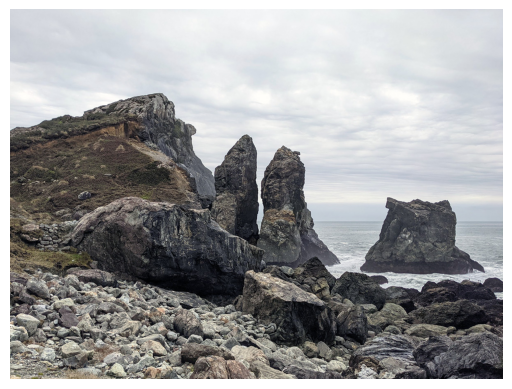

In [60]:
# Fetching test image

from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [61]:
# Instantiate model

from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [62]:
# Configure contribution of each layer
layer_settings = {
    "mixed3": 2.0,
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}

outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name)
                      for name in layer_settings.keys()]
    ]
)

print(f"outputs dict: {outputs_dict}")
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

outputs dict: {'mixed3': <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_2588>, 'mixed4': <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_2620>, 'mixed5': <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_2652>, 'mixed6': <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_2684>, 'mixed7': <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_2716>}


In [63]:
# Loss function
import tensorflow as tf

def compute_loss(input_image):
  features = feature_extractor(input_image)
  loss = tf.zeros(shape=())
  for name in features.keys():
    coeff = layer_settings[name]
    activation = features[name]
    # slice to remove the border effect
    loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
  return loss

In [64]:
# Gradient Ascent

@tf.function
def gradient_ascent_step(image, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(image)
    loss = compute_loss(image)
  grads = tape.gradient(loss, image)
  grads = tf.math.l2_normalize(grads)
  image += learning_rate * grads
  return loss, image

def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
  for i in range(iterations):
    loss, image = gradient_ascent_step(image, learning_rate)
    if max_loss is not None and loss > max_loss:
      break
    print(f"... Loss value at step {i}: {loss:.2f}")
    return image

step = 10.
num_octave = 8
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [65]:
# Imgae processing utilities
import numpy as np

def preprocess_image(image_path):
  img = keras.utils.load_img(image_path)
  img = keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = keras.applications.inception_v3.preprocess_input(img)
  return img

def deprocess_image(img):
  img = img.reshape((img.shape[1], img.shape[2], 3))
  img /= 2.0
  img += 0.5
  img *= 255.
  img = np.clip(img, 0, 255).astype("uint8")
  return img

In [66]:
# Running gradient ascent
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
  print(f"Processing octave {i} with shape {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_ascent_loop(
      img, iterations=iterations, learning_rate=step, max_loss=max_loss
      )
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (85, 113)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 85, 113, 3))
  warnings.warn(msg)


... Loss value at step 0: nan
Processing octave 1 with shape (119, 159)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 119, 159, 3))
  warnings.warn(msg)


... Loss value at step 0: 3.28
Processing octave 2 with shape (167, 223)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 167, 223, 3))
  warnings.warn(msg)


... Loss value at step 0: 2.64
Processing octave 3 with shape (234, 312)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 234, 312, 3))
  warnings.warn(msg)


... Loss value at step 0: 2.34
Processing octave 4 with shape (327, 437)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 327, 437, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 459, 612, 3))
  warnings.warn(msg)


... Loss value at step 0: 2.04
Processing octave 5 with shape (459, 612)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 642, 857, 3))
  warnings.warn(msg)


... Loss value at step 0: 1.88
Processing octave 6 with shape (642, 857)
... Loss value at step 0: 1.86
Processing octave 7 with shape (900, 1200)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2488']
Received: inputs=Tensor(shape=(1, 900, 1200, 3))
  warnings.warn(msg)


... Loss value at step 0: 1.80


In [67]:
# Anti Dream!
def gradient_descent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = compute_loss(img)
        grads = tape.gradient(loss, img)

        # Normalize gradients
        grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-8)

        if max_loss is not None and loss > max_loss:
            break

        # Here's the key: gradient DESCENT = subtract gradients
        img -= learning_rate * grads

    return img


original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
  successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
  print(f"Processing octave {i} with shape {shape}")
  img = tf.image.resize(img, shape)
  img = gradient_descent_loop(
      img, iterations=iterations, learning_rate=step, max_loss=max_loss
      )
  upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
  same_size_original = tf.image.resize(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("anti-dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (85, 113)
Processing octave 1 with shape (119, 159)
Processing octave 2 with shape (167, 223)
Processing octave 3 with shape (234, 312)
Processing octave 4 with shape (327, 437)
Processing octave 5 with shape (459, 612)
Processing octave 6 with shape (642, 857)
Processing octave 7 with shape (900, 1200)


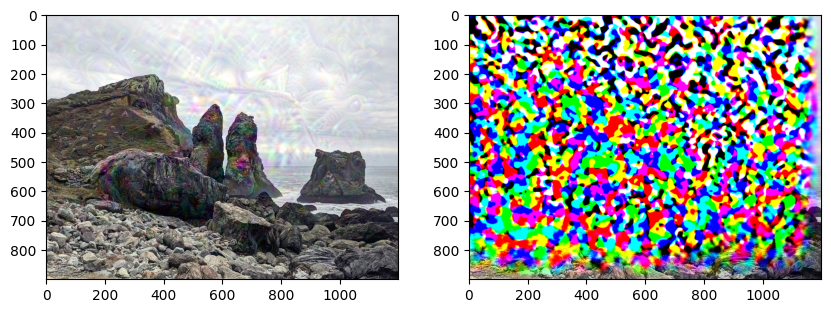

In [77]:
from tensorflow.keras.utils import load_img, img_to_array

img1 = img_to_array(load_img("dream.png"))
img2 = img_to_array(load_img("anti-dream.png"))


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img1.astype("uint8"))
axs[1].imshow(img2.astype("uint8"))

